Imagine we are measuring voltages of a sine wave, and we want to constrain the amplitude and phase.

Our measurements have Gaussian noise of known standard deviation, and occur at known times (assume we can measure time so well that there is practically no uncertainty).

In [1]:
# "y" are our measurements
y = Array([-1.64, 4.63, 6.09, 5.05, 2.66, -0.90, -6.09, -7.16, -2.54, -1.84])
# "noise_std" is the standard deviation of the Gaussian noise on our measurements
noise_std = 1.0

nsamples = length(y)
# "times" are when the measurements were taken (evenly spaced)
times = collect(LinRange(0.0, 2.0*pi, nsamples));

In [2]:
using Plots

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1242


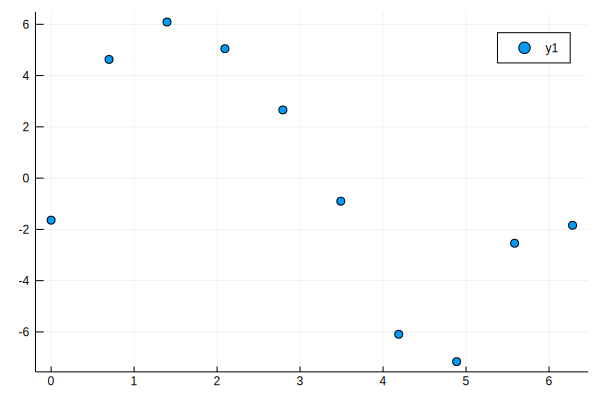

In [9]:
plot(times, y,seriestype="scatter")

Now, we have to write our *model* function.  Our model is that this is a sine wave with parameters of *phase offset* and *amplitude*.

In [6]:
function sine_model(t, phase, amplitude)
    return amplitude * sin.(t .- phase)
end;

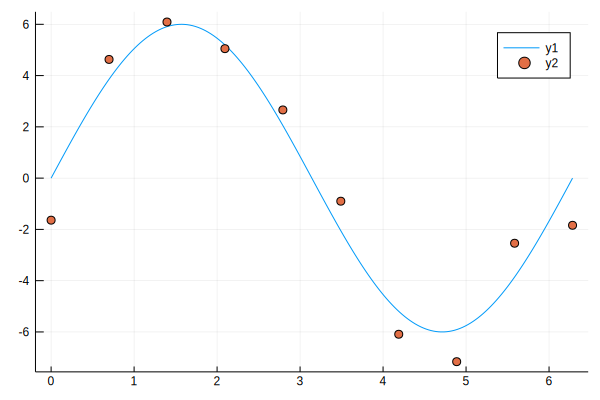

In [10]:
tplot = collect(LinRange(0.0, 2.0*pi, 200));
# I'm going to guess at parameters: phase = 0, amplitude = 6
plot(tplot, sine_model(tplot, 0., 6))
plot!(times, y,seriestype="scatter")

Now, in order to use MCMC, we must write down our *likelihood*.  Given model parameters, how probable are the measurements we made?

In [8]:
function sine_log_likelihood(t, y, phase, amplitude)
    ymodel = sine_model(t, phase, amplitude)
    log_likelihood = -0.5 * sum((y - ymodel).^2 / noise_std.^2)
    return log_likelihood
end;

In [11]:
sine_log_likelihood(times, y, 0., 6.)

-6.261172416426372

In [12]:
sine_log_likelihood(times, y, 0.05, 6.)

-5.560820776311154

Now, since this is a low-dimensional problem, we can just grid up the parameter space and compute the likelihood at each position!  In real problems, you can't do this....

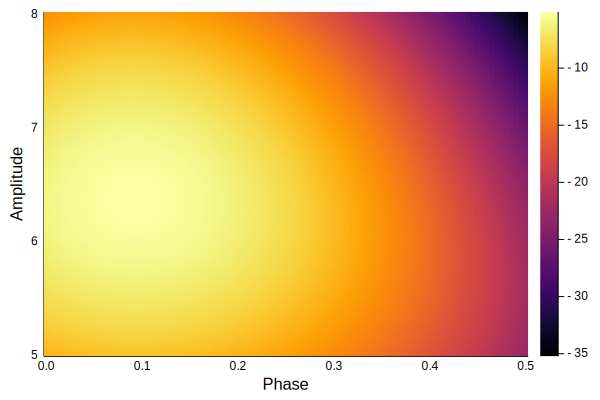

In [13]:
plo,phi = 0., 0.5
alo,ahi = 5., 8.
pp = range(plo, stop=phi, length=100)
aa = range(alo, stop=ahi, length=100)
LL = zeros((length(pp), length(aa)))
for i in 1:length(pp)
    for j in 1:length(aa)
        LL[i, j] = sine_log_likelihood(times, y, pp[j], aa[i])
    end
end
heatmap(pp, aa, LL, xlabel="Phase", ylabel="Amplitude")

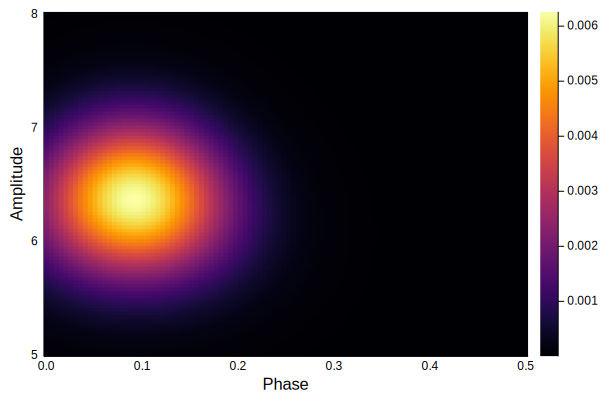

In [14]:
heatmap(pp, aa, exp.(LL), xlabel="Phase", ylabel="Amplitude")

Now, we're going to code up MCMC to see if we can sample this parameter space and get the same answer!

First, we need to go from a log-likelihood to a log-posterior.  This *requires* specifying a *prior* on the parameters.

A common thing to do is to choose a "flat" prior: the prior is constant over the entire range.  This is technically wrong ("improper prior").

In [15]:
function sine_log_posterior(t, y, phase, amplitude)
    log_like = sine_log_likelihood(t, y, phase, amplitude)
    # Flat prior!  No preference for phase, amplitude values.
    log_prior = 0.
    return log_like + log_prior
end;

Now the actual MCMC algorithm!  We need to choose a "proposal distribution" -- how to select the next candidate parameters to jump to.  We will make these Gaussians with fixed variances.

In [16]:
chain = []

# initial parameter guess
param_phase = 0.
param_amp = 6.

# proposal jump sizes
jump_phase = 0.01
jump_amp = 0.1

# initial log-posterior.
logprob = sine_log_posterior(times, y, param_phase, param_amp)

# how many steps to take
nsteps = 1_000

for i in 1:nsteps
    
    # propose new parameter values
    param_phase_new = param_phase + randn() * jump_phase
    param_amp_new   = param_amp   + randn() * jump_amp

    # compute log-posterior at new parameters
    logprob_new = sine_log_posterior(times, y, param_phase_new, param_amp_new)

    if (exp(logprob_new - logprob) >= rand(Float64))
        logprob = logprob_new
        param_phase = param_phase_new
        param_amp   = param_amp_new
    end
    append!(chain, (param_phase, param_amp))
end
# append! makes "chain" a 1-d vector; reshape to a matrix
chain = reshape(chain, (2,Int64(length(chain)/2)))';

In [17]:
chain

1000×2 LinearAlgebra.Adjoint{Any,Array{Any,2}}:
  0.0189993    5.99555
  0.0179451    6.05081
  0.0140954    6.13549
 -0.00132541   6.25027
 -0.0179596    6.16526
 -0.0179596    6.16526
 -0.0170312    6.25356
 -0.0272478    6.32255
 -0.0326671    6.39462
 -0.036954     6.39662
 -0.0265715    6.44799
 -0.0173997    6.52282
  0.000780268  6.30848
  ⋮                   
  0.0140841    5.98791
  0.0116141    5.90602
  0.00365939   5.80781
  0.00451755   5.87974
  0.0194249    5.87473
  0.00925858   5.96727
  0.0324067    5.98698
  0.0278395    6.07528
  0.0264821    6.01815
  0.0288121    6.00788
  0.027116     6.01032
  0.0204137    5.97473

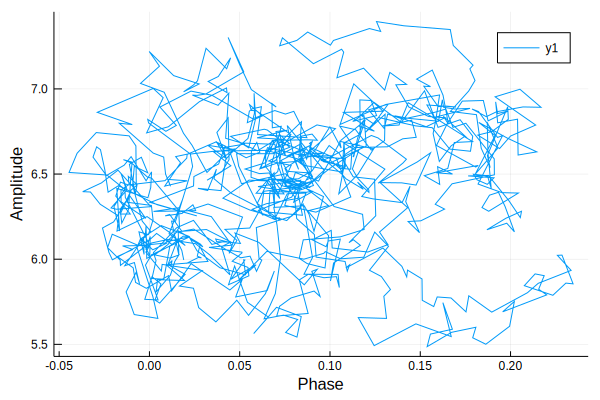

In [18]:
plot(chain[:,1], chain[:,2], xlabel="Phase", ylabel="Amplitude")

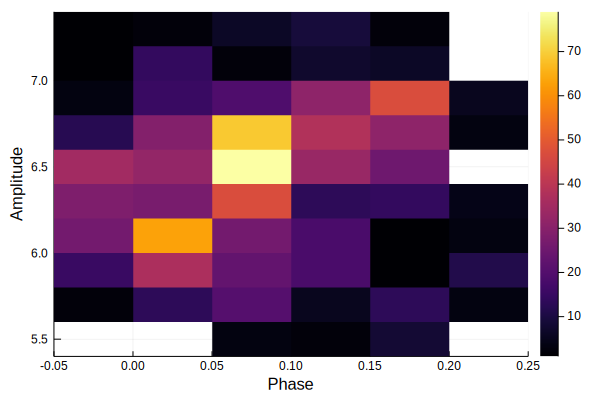

In [19]:
histogram2d(chain[:,1], chain[:,2], xlabel="Phase", ylabel="Amplitude")

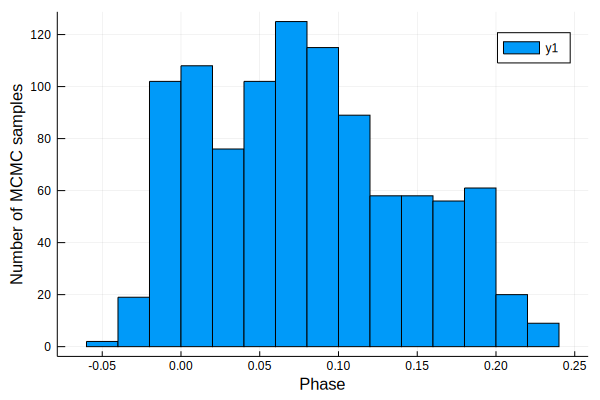

In [20]:
histogram(chain[:,1], xlabel="Phase", ylabel="Number of MCMC samples")

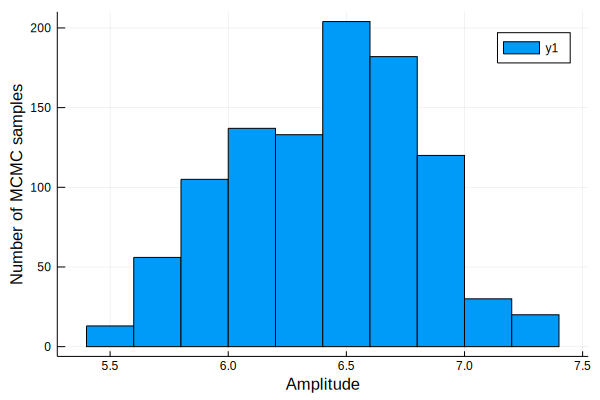

In [21]:
histogram(chain[:,2], xlabel="Amplitude", ylabel="Number of MCMC samples")